<a href="https://colab.research.google.com/github/SoumyaShreeram/Microlensing_with_NeuralNets/blob/master/07_Generating_light_curves_using_Gaussian_Processes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Testing Neural Networks using Gaussian Processes

Author: Soumya Shreeram <br>
Date: 15th May 2020

Import all required python libraries

In [2]:
from google.colab import drive
import os, sys
from time import sleep
import pickle
import importlib
import itertools

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import random
import os
from IPython.display import Image, SVG
from scipy.interpolate import interp1d 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, RationalQuadratic
from sklearn.gaussian_process.kernels import ConstantKernel

%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Activation, InputSpec
from tensorflow.python.keras.layers import Conv1D, Conv2D
from tensorflow.python.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Add, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

TensorFlow 1.x selected.


Mount google drive

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Directory where the `python` files are stored on Google Drive. These imported files are also available in `.ipynb` format on the GitHub repo with same names (without the dr; <strike>`dr`</strike>`0X_sameFileName`). dr stands for drive. 

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

import nb_02i_preprocessing_data as dat
import nb_03_neural_network_designs as nnet

Setting up the path to the data directory

In [0]:
current_dir = os.getcwd()
data_dir = r'/content/gdrive/My Drive/training_set_microlensing/'
save_image_dir = r'/content/gdrive/My Drive/Colab Notebooks/Images/'
save_model_dir = r'/content/gdrive/My Drive/Colab Notebooks/Models/'
save_data_dir = r'/content/gdrive/My Drive/Colab Notebooks/Data/'

## 1. Input parameters

In [0]:
v_t = [500, 300] # transverse velcity
v_t_idx = 0 # choose index value for the velocity you would like (0 or 1)
r_0 = (2,4,10,15,20,30,40,60,80,100) # scale radius
output_class_names = [str(r) for r in r_0 ]

# select type of Interpolation
cubic, linear = False, True

# data loaded with season gaps
season_gaps = True

# if using the new data set generated by Eric (v_500_new, v_500_gaps_new)
new_data_set = True

# generates new interpolated light curves? OR Use previously saved light curves?
generate_new_files, use_saved_file = True, False

## 2. Load the data

There are 10 categories into which the light-curves are classified. Each category is represented by the scale radius `r_0`. For every scale radius, there exists a light-curve whose data points are stored in the 3D array `l_curves`.

In [7]:
# sets the sampling parameters
sample_params = dat.setSamplingParameters(v_t[v_t_idx], data_dir, season_gaps)

# initializes data arrays
class_cat, l_curves, out_catergories, out_radii = dat.initializer(r_0, \
                                                                  sample_params)

for idx, rad in enumerate(r_0):
  filename = dat.getFilename(data_dir, idx, rad, v_t[v_t_idx], sample_params, \
                             season_gaps, new_data_set)
  
  # load data from the file
  l_curves, _, _ = dat.loadData(filename, idx, l_curves, sample_params, idx,\
                                  season_gaps, new_data_set)
  out_catergories[idx*sample_params[0][idx]:(idx+1)*sample_params[0][idx]] = class_cat[1][idx]
  out_radii[idx*sample_params[0][idx]:(idx+1)*sample_params[0][idx]] = r_0[idx]

print('Shape of light curves vector:', np.shape(l_curves))

Shape of light curves vector: (50000, 955, 1)


In [0]:
# load time array, and error of light curves array from 1 sample file for J0158
mjhd = np.load(data_dir+'Light_Curves/mjhd.npy')
l_curves_err = np.load(data_dir+'Light_Curves/lcurves_error.npy')

Loads the ligths arrays (if not generated again)

## 3. Implementing Gaussian Processes
### 3.1 Setting up the Kernel for Gaussian Processor 

The *prior function*, $y$, is specified by the mean, $m(x_i)$, and corvariance function, $k(x_i, x_j)$. Additionally, idependent and identically distributed (iid) Gaussian noise can be added to the prior function; this is specified by the signal variance,  $\sigma^2$. Overall, the labels for the gaussian processor are defined as:

$$y \sim GP(m(x_i), k(x_i, x_j) + \delta_{ij} \sigma^2)$$

The form of $m(x_i)$ and $k(x_i, x_j)$ is chosen during model selection. There are different types of kernels (or covariance functions) that are used here:

1. [**Constant kernel**](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html): It is used as part of a product-kernel where it scales the magnitude of the other factor (kernel) or as part of a sum-kernel, where it modifies the mean of the Gaussian process.
2. [**Radial-basis function kernel**](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RBF.html#sklearn.gaussian_process.kernels.RBF) (**RBF**; aka squared-exponential kernel): It is parameterized by a length scale parameter, $l>0$, and is given as:
$$k(x_i, x_j) = exp\Big(- \frac{d(x_i, x_j)^2}{2l^2}\Big),$$
where $d(x_i, x_j)$ is the Euclidean distance.
3. [**Matérn kernel**](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Matern.html#sklearn.gaussian_process.kernels.Matern): It is a generalization of the RBF kernel and it has an additional parameter, $\nu$,  which controls the smoothness of the resulting function. As $\nu \rightarrow \inf$, this kernel becomes RBF. 
4. [**Rational Quadratic kernel**](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html#sklearn.gaussian_process.kernels.RationalQuadratic): The RationalQuadratic kernel can be seen as a scale mixture (an infinite sum) of RBF kernels with different characteristic length scales. It is parameterized by a length scale parameter $l>0$  and a scale mixture parameter $\alpha > 0$. The kernel is given by:
$$k(x_i, x_j) = \Bigg[1+ exp\Big(- \frac{d(x_i, x_j)^2}{2\alpha l^2}\Big)\Bigg]^{-\alpha}.$$
5. [**White kernel**](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html): The main use-case of this kernel is as part of a sum-kernel where it explains the noise of the signal as independently and identically normally-distributed. The parameter noise_level equals the variance of this noise.



The three different types of kernels tested here are with the corresponding keywords are the following:
1. '*matern*': Constant kernel + Matérn kernel + White Kernel
2. '*RBF*': Constant kernel + RBF kernel + White Kernel
3. '*RationalQuadratic*': Constant kernel + Rational Quadratic kernel + White Kernel


In [0]:
# smoothness parameter of the matérn kernel
nu = 1.5
amplitude = 2.0

# scale mixture parameter
alpha = 1.5

# length-scale parameter
length_scale = 200.0

# white noise level parameter
noise_level = 5.0

kernel_types = ["matern", "RBF", "rational_quadratic"]
# choose a kernel from kernel_types
covkernel = kernel_types[0]

In [0]:
def defineKernel(length_scale, nu, alpha, amplitude, covkernel):
  """
  Function to define the kernel
  @length_scale:: length-scale parameter in the kernel
  @nu:: smoothness parameter for the matérn kernel
  @alpha:: the scale mixture parameter
  @amplitude:: multiplicative factor for the kernels
  @covkernel :: keyword specifying the choise of kernel

  Returns
  @kernel
  """
  background_kernel = ConstantKernel() + WhiteKernel(noise_level=noise_level)

  if covkernel == "matern":
    kernel =  amplitude*Matern(length_scale=length_scale, nu=nu)
  elif covkernel =="RBF": 
    kernel =  amplitude*RBF(length_scale=length_scale)
  elif covkernel == "rational_quadratic":
    kernel = amplitude*RationalQuadratic(length_scale=length_scale, alpha=alpha)
  return kernel+background_kernel

def gprOnSingleLCurve(idx, l_curves, mjhd, l_curves_err, kernel, noise_level):
  """
  Function interpolates the season gaps for a single light curves using Gaussian Processes
  Input parameters:
  @idx :: iterating index
  @l_curves :: y-array corresponding to the magnitude of the light curve (a single spectrum)
  @mjhd :: x-time array
  @l_curves_err :: y-error array corresponding to the error on the magnitude of the y-points
  @kernel :: defines the types of kernel (covariance function) used for model fitting
  @noise_level :: rescaling the error with a factor

  Returns:
  @y_gpr :: the new y-array generated using Gaussian processes regressor
  @y_std :: values representing the standard deviation for the new y-array points
  """  
  y, x, yerr = l_curves[idx,:,0], mjhd.reshape(-1, 1), l_curves_err
  # rescaling yerr with the added noise; x *= y is equivalent to x = x*y
  yerr *= noise_level 

  # builds and fits the regression model used for interpolation
  model = gp.GaussianProcessRegressor(kernel, alpha=yerr).fit(x, y)

  # defines the new reshuffled x-array 
  x_new = np.linspace(x[0], x[-1], num=len(x))

  # predicting the new 'y-array' and 1-sigma 'y_std' array using Gaussian process regressor
  y_gpr, y_std = model.predict(x_new, return_std=True) 
  
  return y_gpr, y_std

Interpolates all the light curves using Gaussian processes regressor

*Todo Note*: The `l_curves_err` array gets changed after every iteration, which is why it is reloaded again after every iteration. Need to sort out where the bug is coming from. 

In [11]:
# initializing a light curve array to store the gaussian proccesses regressed curves
l_curves_gpr = np.array([]),  np.array([])
l_curves_gpr.shape = (0, len(l_curves[0,:,0]),1)

# defines the kernel
kernel = defineKernel(length_scale, nu, alpha, amplitude, covkernel)

# performs gpr on all the light curves
if generate_new_files:
  for num in range(len(r_0)):
    # generate separate idx array for the interpolated light curves as per radius
    idx_array = np.arange(num*sample_params[0][num],(num+1)*sample_params[0][num])
    print('Processing radius: %d, No. of light curves: %d'%(out_radii[num*sample_params[0][num]], len(idx_array)))    
    
    for i, idx in enumerate(idx_array):
      # reloads the array to make sure no inf errors pop up *[arr gets changed after every loop]
      l_curves_err = np.load(data_dir+'Light_Curves/lcurves_error.npy')

      y_gpr, _ = gprOnSingleLCurve(idx, l_curves, mjhd, l_curves_err, kernel, noise_level)

      # setting the shape same as that on l_curves array
      y_gpr.shape = (len(y_gpr), 1)
      
      # appending the y-gpr and y-std arrays
      l_curves_gpr = np.append(l_curves_gpr, [y_gpr], axis=0)
      
      # shows the progress
      dat.showProgress(i, 5000)
      
    # save file
    dat.saveFile(data_dir, 'Light_Curves/v500_GP/lcurves_SeasonGaps_GPR_radii_%d'%out_radii[num*sample_params[0][num]], l_curves_gpr)
  
  # prints the light curves array shape
  dat.printLcurvesShape(l_curves_gpr)
    
# the new reshuffled time-array 
mjhd_gpr = np.linspace(mjhd[0], mjhd[-1], num=len(mjhd))

[====================] 100%

### 3.2 Reloads and save the light curves as one file

In [46]:
# initializing a light curve array to store the gaussian proccesses regressed curves
l_curves_gpr = np.array([])
l_curves_gpr.shape = (0, len(l_curves[0,:,0]),1)
for i in range(len(r_0)):
  # loads the file
  filename = 'Light_Curves/v500_GP/lcurves_SeasonGaps_GPR_radii_%d'%r_0[i]
  y_gpr = dat.loadFile(data_dir,filename)
  
  print(np.shape(y_gpr), ' : ', r_0[i])
  # appends the light curves
  l_curves_gpr = np.row_stack((l_curves_gpr, y_gpr))

# prints the light curves shape
dat.printLcurvesShape(l_curves_gpr) 

# save file
dat.saveFile(data_dir, 'Light_Curves/lcurves_SeasonGaps_GPR_%d'%len(l_curves_gpr), l_curves_gpr)

(5000, 955, 1)  :  2
(5000, 955, 1)  :  4
(5000, 955, 1)  :  10
(5000, 955, 1)  :  15
(5000, 955, 1)  :  20
(5000, 955, 1)  :  30
(5000, 955, 1)  :  40
(5000, 955, 1)  :  60
(5000, 955, 1)  :  80
(4999, 955, 1)  :  100
shape of light curves arrays: (49999, 955, 1)


### 3.2 Plots some random light curves

2.0
4.0


[None, None]

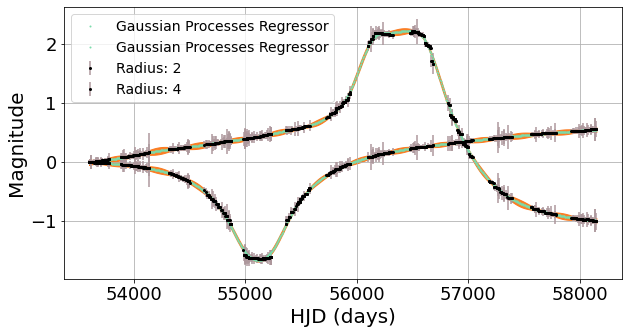

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))

# choosen light curves
n = [2990, 9900]
y_gpr, y_std = [], []
colors = ['#f70008',  '#f70008']

importlib.reload(dat)

for i in range(len(n)):
  l_curves_err = np.load(data_dir+'Light_Curves/lcurves_error.npy')
  y_gpr, y_std = gprOnSingleLCurve(n[i], l_curves, mjhd, l_curves_err, kernel, noise_level) 

  # plots the data for chosen indicies in n
  dat.plotGaussianProcessesRegressor(ax, n[i], l_curves, y_gpr, y_std, mjhd_gpr,\
                                     mjhd, l_curves_err, out_radii)

# axis labels
dat.setLabels(ax, 'HJD (days)', 'Magnitude', ticks=True, legend=True)

# saves figures
fig.savefig(save_image_dir+'/GP_interpolated_lcurves.png') 
  
[print(out_radii[number]) for number in n]